Linear regression to predict streamflow. Streamflow is divided by 24 to match forcing resolution

In [ ]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn import metrics, svm, neural_network, ensemble
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
from src import load_data, evaluate

In [5]:
data_runoff = load_data.load_discharge_gr4j_vic()

In [6]:
data_runoff[pd.isna(data_runoff['runoff'])].groupby(['station'])['date'].count()  # Count NAs per station

station
02GC018       44
02GG013       31
04214500    1003
Name: date, dtype: int64

In [11]:
# For each station, read which grid cells belong to its subwatershed
station_cell_mapping = pd.read_csv('station_cell_mapping.csv', skiprows=1, names=['station', 'lat', 'lon', 'row', 'col', 'area'])

In [ ]:
rdrs_data = load_data.load_rdrs_forcings()

In [ ]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7 * 24
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history // 24 + 1)
use_runoff_history = False

predictions = {}
actuals = {}
for station in data_runoff['station'].unique():
    print(station)
    station_data = data_runoff[data_runoff['station'] == station].set_index('date')
    station_cell_ids = 39 * station_cell_mapping[station_cell_mapping['station'] == station]['col'] \
        + station_cell_mapping[station_cell_mapping['station'] == station]['row']
    station_rdrs = rdrs_data.filter(regex='_(' + '|'.join(map(lambda x: str(x), station_cell_ids)) + ')$', axis=1)
    
    if any(station_data['runoff'].isna()):
        station_data = station_data[~pd.isna(station_data['runoff'])]
        print('Station', station, 'had NA runoff values')
    station_data = station_data.resample('1H').ffill()
    station_data['runoff'] = station_data['runoff'] / 24
    
    station_data = station_data.join(station_rdrs)#, left_index=True, right_index=True, direction='nearest')
    for i in range(1, history + 1):
        station_data = station_data.join(station_rdrs.shift(i, axis=0), rsuffix='_-{}'.format(i))
        if use_runoff_history:
            station_data['runoff_-{}'.format(i)] = station_data['runoff'].shift(i, axis=0)
    
    station_train = station_data.loc[train_start : '2012-12-31']
    station_test = station_data.loc['2013-01-01' : '2013-12-31']
    print('  Fitting model')
    m = linear_model.LinearRegression()
    m.fit(station_train.drop(['station', 'runoff'], axis=1), station_train['runoff'])
    
    station_test = station_test[~pd.isna(station_test['runoff'])]
    if len(station_test) == 0:
        print('Skipping', station)
        continue
        
    predict = pd.DataFrame(index=station_test.index)
    predict = predict.join(station_test.drop(['station', 'runoff'], axis=1))
    predict['runoff'] = np.nan
    if use_runoff_history:
        for i in range(history):
            for j in range(i + 1, history + 1):
                predict.iloc[i]['runoff_-{}'.format(j)] = station_test.iloc[i]['runoff_-{}'.format(j)]
    print('  Predicting')
    if not use_runoff_history:
        predict['runoff'] = m.predict(predict.drop('runoff', axis=1))
    else:
        for i in range(len(predict)):
            predict.iloc[i]['runoff'] = m.predict([predict.iloc[i].drop('runoff')])[0]
            for j in range(1, history + 1):
                if (i + j) >= len(predict):
                    break
                predict.iloc[i + j]['runoff_-{}'.format(j)] = predict.iloc[i]['runoff']
    predictions[station] = predict
    actuals[station] = station_test['runoff']

04159492
  Fitting model
  Predicting
04200500
  Fitting model


04159492 
	RMSE (clipped to 0): 25.005264139875106
	NSE: (clipped to 0) 0.18150391506918817
04200500 
	RMSE (clipped to 0): 34.11814197253985
	NSE: (clipped to 0) 0.047627309625517644
Median NSE (clipped to 0) 0.11456561234735291 / Min 0.047627309625517644 / Max 0.18150391506918817


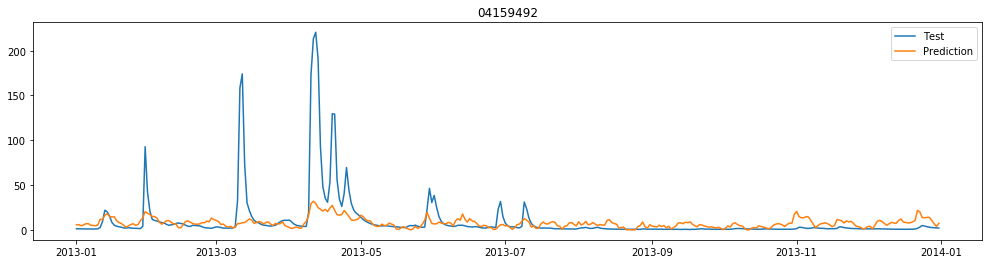

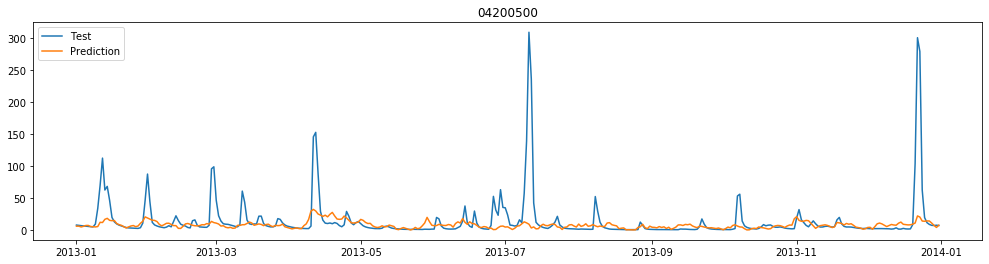

In [55]:
# Evaluate each station
nse_list = []
plot_list = ['04159492', '04200500']
for station, predict in predictions.items():
    nse = evaluate.evaluate_hourly(station, actuals[station], predict['runoff'], plot=station in plot_list)
    nse_list.append(nse)
    
    print(station, '\tNSE: (clipped to 0)', nse_list[-1])
    
print('Median NSE (clipped to 0)', np.median(nse_list), '/ Min', np.min(nse_list), '/ Max', np.max(nse_list))